In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_banks_list = pd.read_csv("live_data/netc_banks_data.csv")

In [4]:
df = pd.read_csv("live_data/NETC_Monthly_Transactions.csv")

In [5]:
df

,Date,Volume (Mn),Value (Cr)
0,2025-01-01,12.32,209.62
1,2025-01-02,11.81,206.10
2,2025-01-03,11.73,206.90
3,2025-01-04,12.26,212.49
4,2025-01-05,12.72,218.71
...,...,...,...
73,2025-03-15,10.73,170.49
74,2025-03-16,12.71,202.32
75,2025-03-17,11.67,196.60
76,2025-03-18,11.64,208.41


In [6]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# 1. Summary Statistics
print("\nSummary Statistics:")
print(df[['Volume (Mn)', 'Value (Cr)']].describe())


Summary Statistics:
       Volume (Mn)  Value (Cr)
count    78.000000   78.000000
mean     12.751538  221.815897
std       1.118947   18.058384
min       8.980000  158.780000
25%      12.042500  212.395000
50%      12.620000  223.360000
75%      13.457500  232.227500
max      15.190000  257.170000


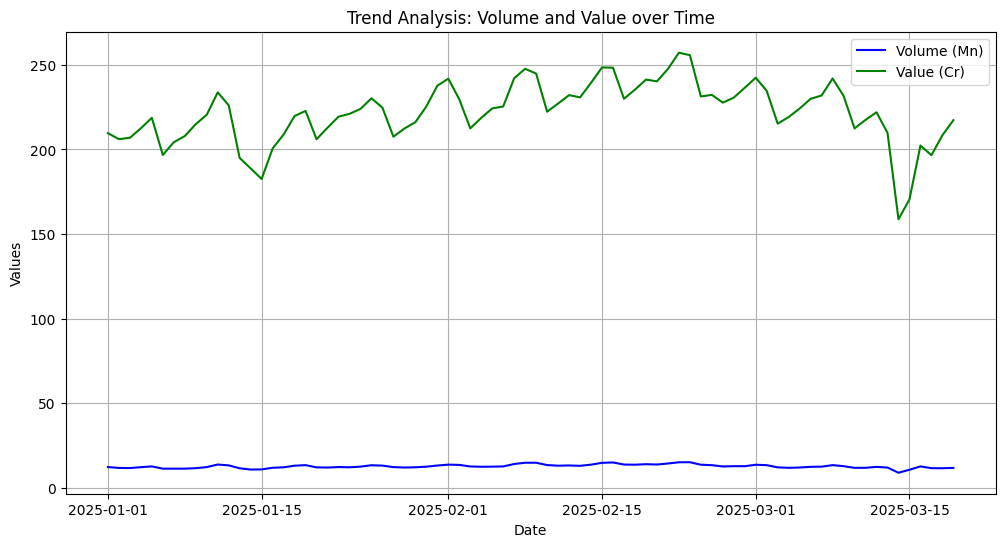

In [7]:
# 2. Trend Analysis
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Volume (Mn)'], label='Volume (Mn)', color='blue')
plt.plot(df['Date'], df['Value (Cr)'], label='Value (Cr)', color='green')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Trend Analysis: Volume and Value over Time')
plt.legend()
plt.grid()
plt.show()

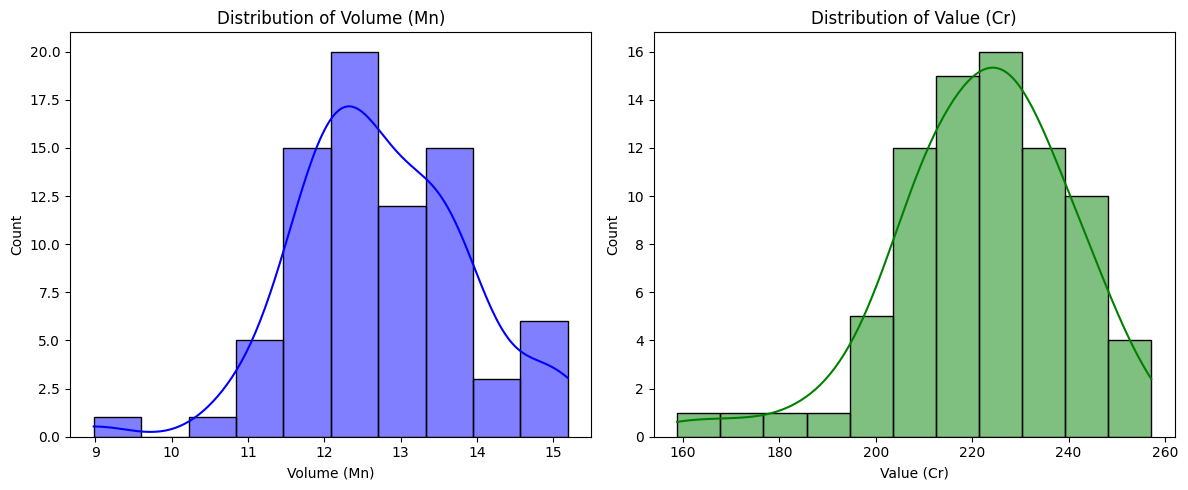

In [8]:
# 3. Distribution Analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Volume (Mn)'], kde=True, color='blue')
plt.title('Distribution of Volume (Mn)')

plt.subplot(1, 2, 2)
sns.histplot(df['Value (Cr)'], kde=True, color='green')
plt.title('Distribution of Value (Cr)')
plt.tight_layout()
plt.show()

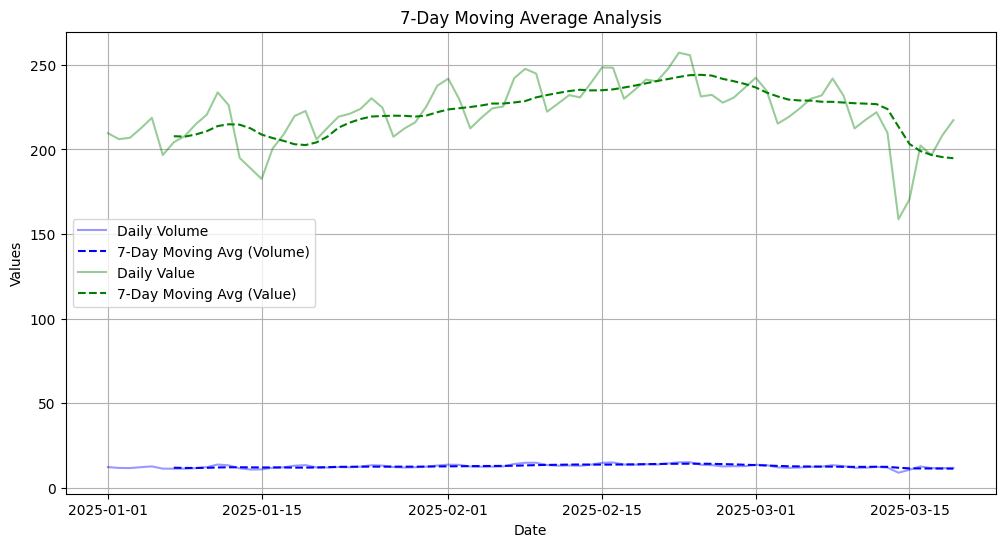

In [9]:
# 5. Moving Averages (7-day rolling average)
df['Volume_7D_MA'] = df['Volume (Mn)'].rolling(window=7).mean()
df['Value_7D_MA'] = df['Value (Cr)'].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Volume (Mn)'], label='Daily Volume', color='blue', alpha=0.4)
plt.plot(df['Date'], df['Volume_7D_MA'], label='7-Day Moving Avg (Volume)', color='blue', linestyle='--')
plt.plot(df['Date'], df['Value (Cr)'], label='Daily Value', color='green', alpha=0.4)
plt.plot(df['Date'], df['Value_7D_MA'], label='7-Day Moving Avg (Value)', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('7-Day Moving Average Analysis')
plt.legend()
plt.grid()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet

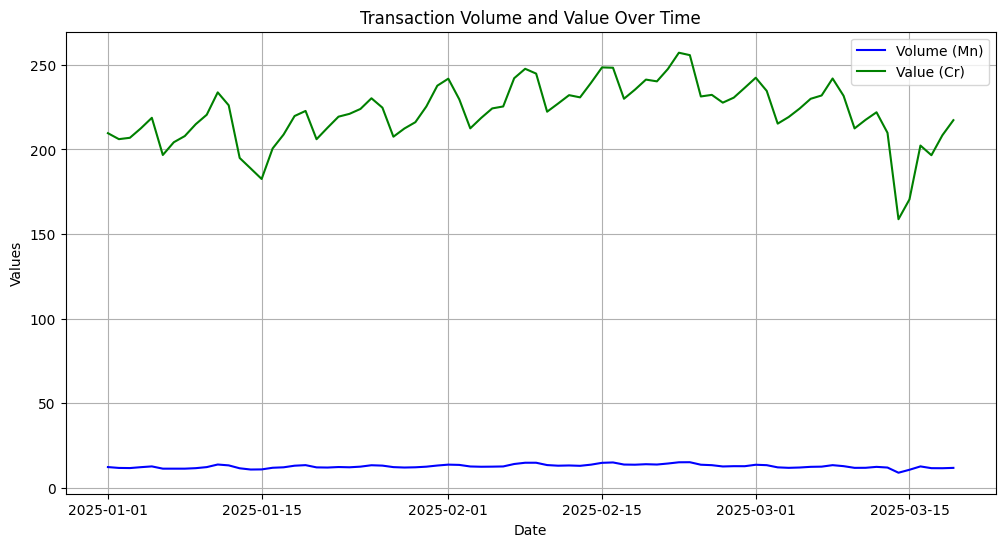

In [11]:
# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Volume (Mn)'], label='Volume (Mn)', color='blue')
plt.plot(df.index, df['Value (Cr)'], label='Value (Cr)', color='green')
plt.title('Transaction Volume and Value Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

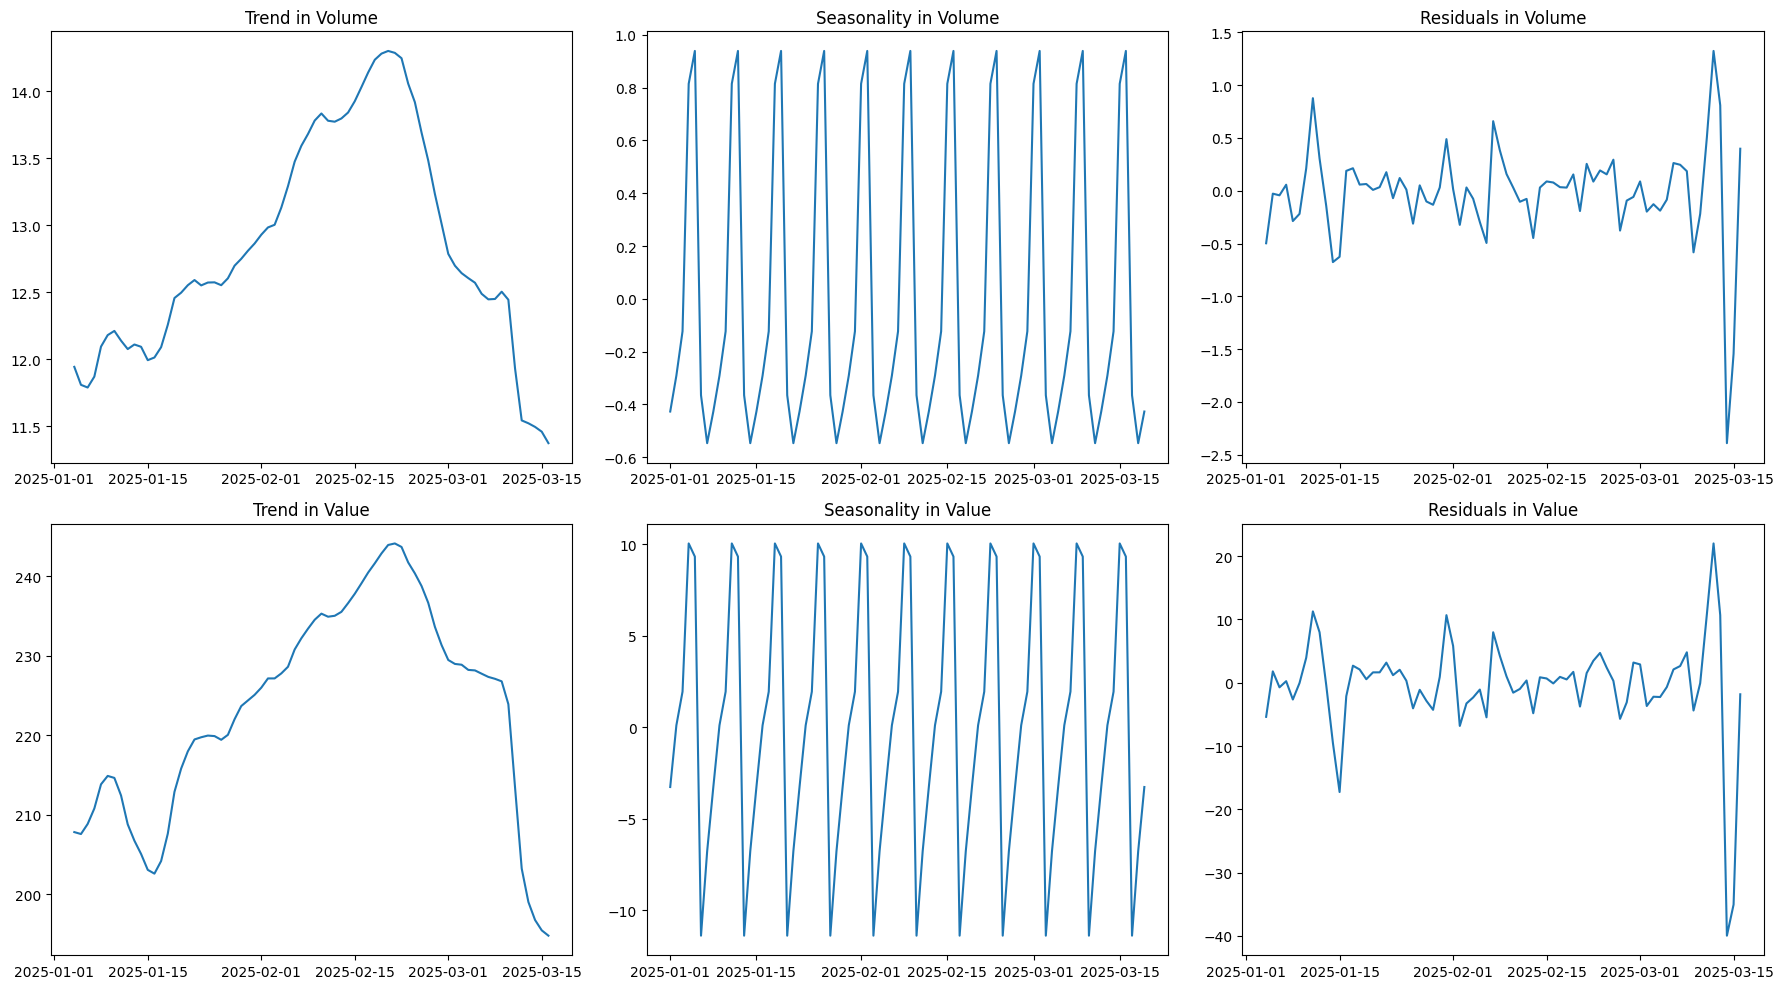

In [12]:

# --------------------------------------
# 1. Trend Detection using Decomposition
# --------------------------------------
decompose_vol = seasonal_decompose(df['Volume (Mn)'], model='additive', period=7)
decompose_val = seasonal_decompose(df['Value (Cr)'], model='additive', period=7)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes[0, 0].plot(decompose_vol.trend)
axes[0, 0].set_title('Trend in Volume')
axes[0, 1].plot(decompose_vol.seasonal)
axes[0, 1].set_title('Seasonality in Volume')
axes[0, 2].plot(decompose_vol.resid)
axes[0, 2].set_title('Residuals in Volume')

axes[1, 0].plot(decompose_val.trend)
axes[1, 0].set_title('Trend in Value')
axes[1, 1].plot(decompose_val.seasonal)
axes[1, 1].set_title('Seasonality in Value')
axes[1, 2].plot(decompose_val.resid)
axes[1, 2].set_title('Residuals in Value')

plt.tight_layout()
plt.show()



In [13]:
# --------------------------------------
# 2. Stationarity Check (ADF Test)
# --------------------------------------
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Series is Stationary")
    else:
        print("Series is Not Stationary")

print("ADF Test for Volume:")
adf_test(df['Volume (Mn)'])
print("\nADF Test for Value:")
adf_test(df['Value (Cr)'])



ADF Test for Volume:
ADF Statistic: -1.235949359418163
p-value: 0.6579432563273414
Series is Not Stationary

ADF Test for Value:
ADF Statistic: -0.8979724099118316
p-value: 0.7886393988121192
Series is Not Stationary


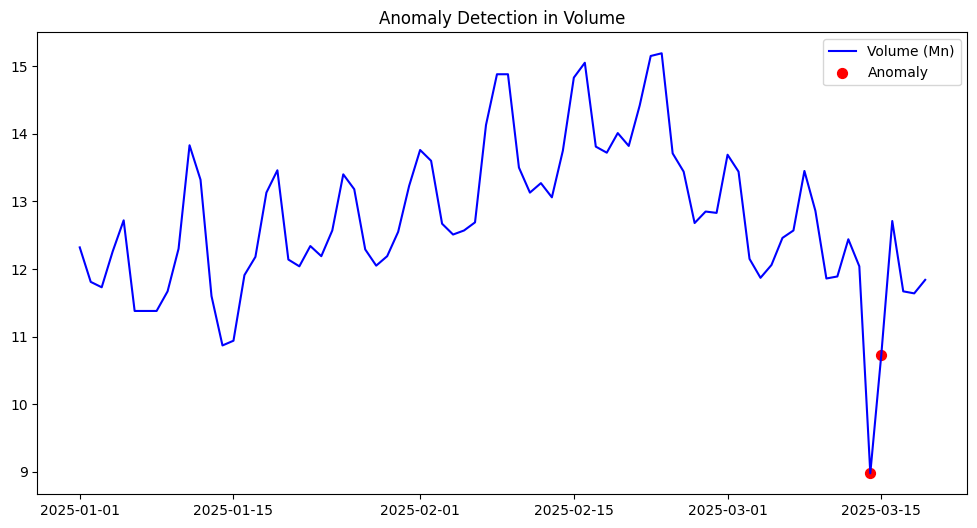

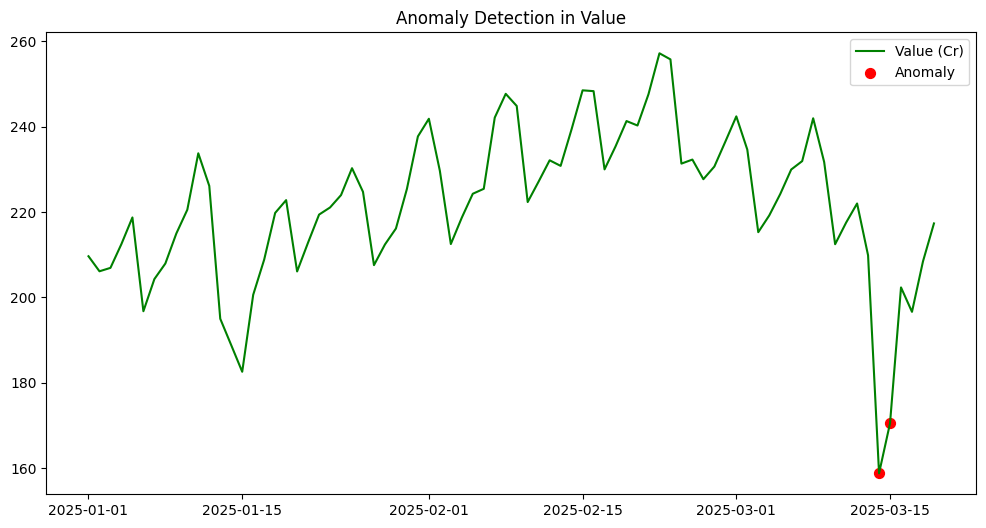

In [14]:
# --------------------------------------
# 3. Anomaly Detection using Residuals
# --------------------------------------
df['Residuals_Volume'] = decompose_vol.resid
df['Residuals_Value'] = decompose_val.resid

threshold_vol = 3 * df['Residuals_Volume'].std()
threshold_val = 3 * df['Residuals_Value'].std()

anomalies_vol = df[np.abs(df['Residuals_Volume']) > threshold_vol]
anomalies_val = df[np.abs(df['Residuals_Value']) > threshold_val]

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Volume (Mn)'], label='Volume (Mn)', color='blue')
plt.scatter(anomalies_vol.index, anomalies_vol['Volume (Mn)'], color='red', label='Anomaly', s=50)
plt.title('Anomaly Detection in Volume')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Value (Cr)'], label='Value (Cr)', color='green')
plt.scatter(anomalies_val.index, anomalies_val['Value (Cr)'], color='red', label='Anomaly', s=50)
plt.title('Anomaly Detection in Value')
plt.legend()
plt.show()


20:45:50 - cmdstanpy - INFO - Chain [1] start processing
20:45:55 - cmdstanpy - INFO - Chain [1] done processing
20:45:56 - cmdstanpy - INFO - Chain [1] start processing
20:45:56 - cmdstanpy - INFO - Chain [1] done processing


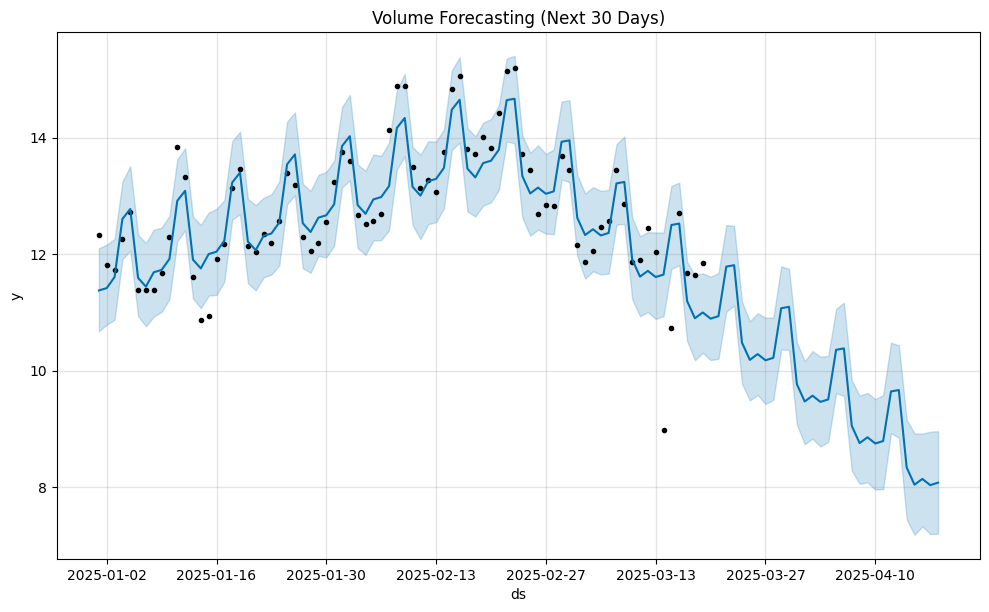

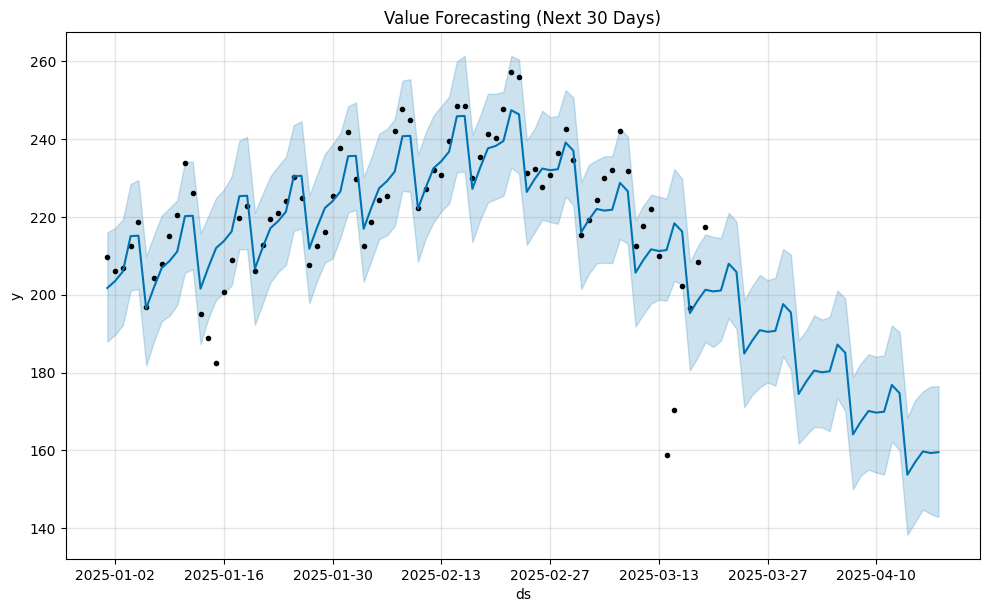

In [15]:

# --------------------------------------
# 4. Forecasting using Prophet
# --------------------------------------
# Prepare data for Prophet (Volume)
df_prophet_vol = df.reset_index()[['Date', 'Volume (Mn)']].rename(columns={'Date': 'ds', 'Volume (Mn)': 'y'})
model_vol = Prophet()
model_vol.fit(df_prophet_vol)

future_vol = model_vol.make_future_dataframe(periods=30)
forecast_vol = model_vol.predict(future_vol)

# Prepare data for Prophet (Value)
df_prophet_val = df.reset_index()[['Date', 'Value (Cr)']].rename(columns={'Date': 'ds', 'Value (Cr)': 'y'})
model_val = Prophet()
model_val.fit(df_prophet_val)

future_val = model_val.make_future_dataframe(periods=30)
forecast_val = model_val.predict(future_val)

# Plot Forecasting Results
model_vol.plot(forecast_vol)
plt.title('Volume Forecasting (Next 30 Days)')
plt.show()

model_val.plot(forecast_val)
plt.title('Value Forecasting (Next 30 Days)')
plt.show()

In [4]:
df_yearly = pd.read_csv("live_data/netc_yearly_data.csv")
df_yearly.head()

,Month,No. of Banks Live on NETC,Tag Issuance (In Nos.),Volume (In Mn),Amount (In Cr)
0,Feb-25,38,105972646,383.90,6601.13
1,Jan-25,38,103174571,380.32,6613.72
2,Dec-24,38,103174571,381.98,6642.21
3,Nov-24,38,101752520,358.84,6070.44
4,Oct-24,38,100319978,344.96,6114.92
